In [1]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from tqdm.notebook import tqdm

In [18]:
left_files = natsorted(glob('left_imgs/*.png'))
right_files = natsorted(glob('right_imgs/*.png'))
disp_files = natsorted(glob('disparities/*.png'))

left_file = left_files[0]
right_file = right_files[0]
disp_file = disp_files[0]

In [3]:
block_size = 5
max_disparity = 16 # must be the multiples of 16
rmse_sum = 0

left_img = cv2.imread(left_file, 0)
right_img = cv2.imread(right_file, 0)
disp_gt_img = cv2.imread(disp_file, 0).astype(np.float32)

stereo = cv2.StereoBM_create(numDisparities=max_disparity, blockSize=block_size)
disparity = stereo.compute(left_img, right_img)
disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Error
mask = np.logical_or(disparity == 0, disp_gt_img == 0)
masked_sq_err = np.ma.array(np.square(disparity - disp_gt_img), mask = mask)
rmse = np.sqrt(masked_sq_err.mean())

print(rmse)

26.50832637093652


In [29]:
# Block Matching alg
def stereo_best_rmse(left_img, right_img, disp_gt_img):
    rmse_best = 10000
    disparity_best = np.zeros_like(disp_gt_img)
    for disp in range(100):
        for block in range(100):
            max_disparity = disp * 16
            block_size = 5 + block * 2

            stereo = cv2.StereoBM_create(numDisparities=max_disparity, blockSize=block_size)
            disparity = stereo.compute(left_img, right_img)
            disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            # Error
            mask = np.logical_or(disparity == 0, disp_gt_img == 0)
            masked_sq_err = np.ma.array(np.square(disparity - disp_gt_img), mask = mask)
            rmse = np.sqrt(masked_sq_err.mean())

            # Find the best rmse using iteration
            if rmse < rmse_best:
                rmse_best = rmse
                disparity_best = disparity

    return disparity_best, rmse_best

0it [00:00, ?it/s]

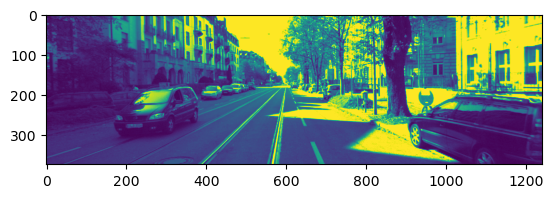

the rmse is 1.392747143308215


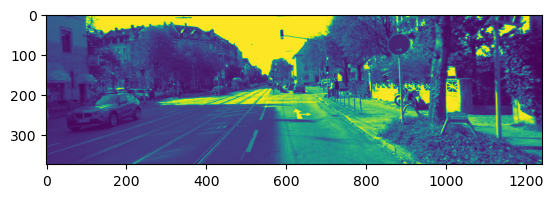

the rmse is 3.7746353627483713


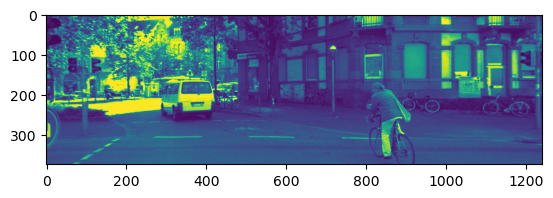

the rmse is 3.0955194102331305


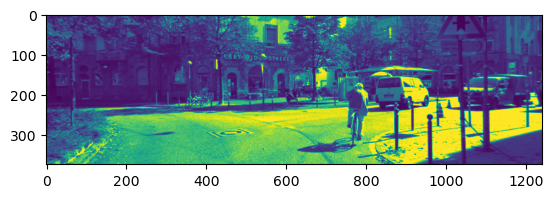

the rmse is 5.686951830995286


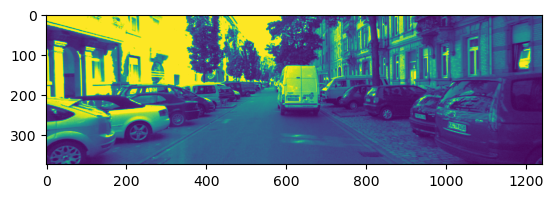

the rmse is 0.16954040458678513
the best rmse is 2.8238788303743574


In [30]:
rmse_sum = 0

for left_file, right_file, disp_gt_file in tqdm(zip(left_files, right_files, disp_gt_img)):
    left_img = cv2.imread(left_file, 0)
    right_img = cv2.imread(right_file, 0)
    disp_gt_img = cv2.imread(disp_file, 0).astype(np.float32)
    
    plt.imshow(left_img)
    plt.show()

    disparity_best, rmse_best = stereo_best_rmse(left_img, right_img, disp_gt_img)
    print("the rmse is", rmse_best)
    rmse_sum += rmse_best

rmse_last = rmse_sum / len(left_files)

print("the best rmse is", rmse_last)

In [17]:
def SGBM_best_rmse(left_img, right_img, disp_gt_img):
    rmse_best = 10000
    disparity_best = np.zeros_like(disp_gt_img)

    max_disp_range = 20
    block_size_range = 50

    for disp in range(max_disp_range):
        max_disparity = disp * 16

        for block in range(block_size_range):
            block_size = 5 + block * 2

            stereo = cv2.StereoSGBM_create(
                minDisparity=0,
                numDisparities=max_disparity,
                blockSize=block_size
            )

            disparity = stereo.compute(left_img, right_img)
            disparity = cv2.normalize(disparity, None, alpha=0, beta=max_disparity, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

            # Error
            mask = np.logical_or(disparity == 0, disp_gt_img == 0)
            masked_sq_err = np.ma.array(np.square(disparity - disp_gt_img), mask=mask)
            rmse = np.sqrt(masked_sq_err.mean())

            # Find the best rmse using iteration
            if rmse < rmse_best:
                rmse_best = rmse
                disparity_best = disparity

    return disparity_best, rmse_best

0it [00:00, ?it/s]

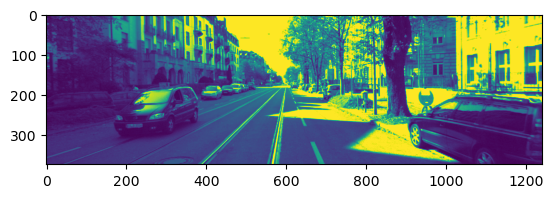

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\include\opencv2/core/utils/buffer_area.private.hpp:70: error: (-215:Assertion failed) count > 0 in function 'cv::utils::BufferArea::allocate'


In [24]:
rmse_sum = 0

for left_file, right_file, disp_gt_file in tqdm(zip(left_files, right_files, disp_gt_img)):
    left_img = cv2.imread(left_file, 0)
    right_img = cv2.imread(right_file, 0)
    disp_gt_img = cv2.imread(disp_file, 0).astype(np.float32)

    # left_img = np.array(Image.open(left_file))
    # right_img = np.array(Image.open(right_file))
    # left_gray = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    # right_gray = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    
    plt.imshow(left_img)
    plt.show()

    disparity_best, rmse_best = SGBM_best_rmse(left_img, right_img, disp_gt_img)
    print("the rmse is", rmse_best)
    rmse_sum += rmse_best

rmse_last = rmse_sum / len(left_files)

print("the best rmse is", rmse_last)